In [1]:
import numpy as np
from fytok.Tokamak import Tokamak
from fytok.utils.load_scenario import load_scenario


In [2]:
scenario = load_scenario("/home/salmon/workspace/data/15MA inductive - burn")
tok = Tokamak("ITER",
              name=scenario["name"],
              description=scenario["description"],
              core_profiles={**scenario["core_profiles"],
                             "$default_value": {"profiles_1d": {"grid": {
                                 "rho_tor_norm": np.linspace(0, 1.0, 100),                                 
                             }}}
                             },
              equilibrium={**scenario["equilibrium"],
                           "code": {"name":  "freegs", "parameters": {"boundary": "fixed"}},
                           "$default_value": {"time_slice": {
                               "boundary": {"psi_norm": 0.99},
                               "coordinate_system": {"grid": {"dim1": 256, "dim2": 128}}
                           }}}
              )


2023-09-13 13:07:43,270 INFO [spdm]: Load scenario/profiles from /home/salmon/workspace/data/15MA inductive - burn/15MA Inductive at burn-ASTRA.xls
2023-09-13 13:07:43,410 INFO [spdm]: Load module spdm.plugins.data.plugin_geqdsk from /home/salmon/workspace/fytok/../SpDB/python/spdm/plugins/data/plugin_geqdsk.py
2023-09-13 13:07:43,420 DEBUG [spdm] /home/salmon/workspace/fytok/../SpDB/python/spdm/plugins/data/plugin_geqdsk.py:358:__init__: Open File URITuple(protocol=None, authority=None, path=PosixPath('/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt'), query=None, fragment=None) mode=Mode.read
2023-09-13 13:07:43,445 INFO [spdm]: Load scenario/equilibrium from /home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt
2023-09-13 13:07:43,456 INFO [spdm]: Load module spdm.plugins.data.plugin_xml from /home/salmon/work

AttributeError: 'NoneType' object has no attribute 'child'

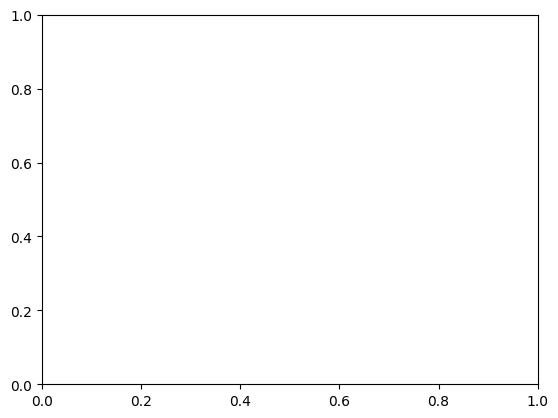

In [4]:
tok.wall